In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import cvxpy
from matplotlib.animation import FFMpegWriter

print("cvxpy version:", cvxpy.__version__)

cvxpy version: 1.1.13


### Constants for pendulum and MPC

In [2]:
# Required constants for pendulum
L = 2.0  # length of bar
mcart = 1.0  # [kg]
mbob = 0.3  # [kg]
g = 9.8  # [m/s^2]

# Required constants for MPC
Q = np.diag([0.0, 1.0, 1.0, 0.0])
R = np.diag([0.01])
nx = 4   # number of state
nu = 1   # number of input
horizon = 30  # Horizon length
dt = 0.1  # time tick
animation = True

In [3]:
def simulation(x, u):
    A, B = get_model_matrix()
    x = np.dot(A, x) + np.dot(B, u)
    return x

In [4]:
def flatten_matrix(a):
    return np.array(a).flatten()

In [5]:
def get_model_matrix():

    # Model Parameter normal lineraized
    A = np.array([
        [0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, mbob * g / mcart, 0.0],
        [0.0, 0.0, 0.0, 1.0],
        [0.0, 0.0, g * (mcart + mbob) / (L * mcart), 0.0]
    ])
    A = np.eye(nx) + dt * A
    B = np.array([
        [0.0],
        [1.0 / mcart],
        [0.0],
        [1.0 / (L * mcart)]
    ])
    B = dt * B

    return A, B

In [6]:
def animate(x):
    plt.clf()
    px = float(x[0])
    theta = float(x[2])
    show_cart(px, theta)
    plt.xlim([-5.0, 2.0])
    plt.pause(0.001)

### Simulation

In [7]:
def run_normal_control():
    x0 = np.array([[0.0],[0.0],[0.6],[0.0]])
    u_lst, x_lst = [], []
    x = np.copy(x0)

    for i in range(50):
        ox, dx, otheta, dtheta, ou = mpc_control(x)
        u = ou[0]
        x = simulation(x, u)
        u_lst.append(u)
        x_lst.append(x)

        if animation:
            animate(x)
    return u_lst, x_lst

### Main MPC control function

In [8]:
def mpc_control(x0):

    x = cvxpy.Variable((nx, horizon + 1))
    u = cvxpy.Variable((nu, horizon))

    A, B = get_model_matrix()
    
    cost = 0.0
    constr = []
    for t in range(horizon):
        cost += cvxpy.quad_form(x[:, t + 1], Q)
        cost += cvxpy.quad_form(u[:, t], R)
        constr += [x[:, t + 1] == A @ x[:, t] + B @ u[:, t]]

    constr += [x[:, 0] == x0[:, 0]]
    prob = cvxpy.Problem(cvxpy.Minimize(cost), constr)

    start = time.time()
    prob.solve(verbose=False)
    #print('x', x.value.shape, x.value)
    #print('u', u.value.shape, u.value)
    elapsed_time = time.time() - start
    print("calc time:{0} [sec]".format(elapsed_time))

    if prob.status == cvxpy.OPTIMAL:
        ox = flatten_matrix(x.value[0, :])
        dx = flatten_matrix(x.value[1, :])
        theta = flatten_matrix(x.value[2, :])
        dtheta = flatten_matrix(x.value[3, :])

        ou = flatten_matrix(u.value[0, :])
    
    return ox, dx, theta, dtheta, ou

### Visualizations

In [9]:
def show_cart(xt, theta):
    cart_w = 1.0
    cart_h = 0.5
    radius = 0.1

    cx = np.matrix([-cart_w / 2.0, cart_w / 2.0, cart_w / 2.0, -cart_w / 2.0, -cart_w / 2.0])
    cy = np.matrix([0.0, 0.0, cart_h, cart_h, 0.0])
    cy += radius * 2.0

    cx = cx + xt

    bx = np.matrix([0.0, L * math.sin(-theta)])
    bx += xt
    by = np.matrix([cart_h, L * math.cos(-theta) + cart_h])
    by += radius * 2.0

    angles = np.arange(0.0, math.pi * 2.0, math.radians(3.0))
    ox = [radius * math.cos(a) for a in angles]
    oy = [radius * math.sin(a) for a in angles]

    rwx = np.copy(ox) + cart_w / 4.0 + xt
    rwy = np.copy(oy) + radius
    lwx = np.copy(ox) - cart_w / 4.0 + xt
    lwy = np.copy(oy) + radius

    wx = np.copy(ox) + float(bx[0, -1])
    wy = np.copy(oy) + float(by[0, -1])
    
    plt.plot(flatten_matrix(cx), flatten_matrix(cy), "-b")
    plt.plot(flatten_matrix(bx), flatten_matrix(by), "-k")
    plt.plot(flatten_matrix(rwx), flatten_matrix(rwy), "-k")
    plt.plot(flatten_matrix(lwx), flatten_matrix(lwy), "-k")
    plt.plot(flatten_matrix(wx), flatten_matrix(wy), "-k")
    plt.title("x:" + str(round(xt, 2)) + ",theta:" + str(round(math.degrees(theta), 2)))

    plt.axis("equal")

In [10]:
def visualize_test():
    angles = np.arange(-math.pi / 2.0, math.pi / 2.0, math.radians(1.0))
    xl = [2.0 * math.cos(i) for i in angles]

    for x, theta in zip(xl, angles):
        plt.clf()
        show_cart(x, theta)
        plt.pause(0.001)

calc time:0.34088993072509766 [sec]


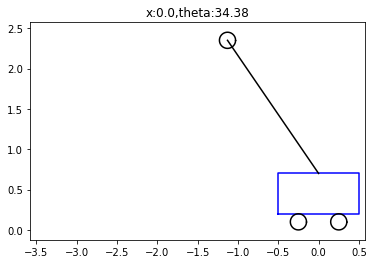

calc time:0.19367718696594238 [sec]


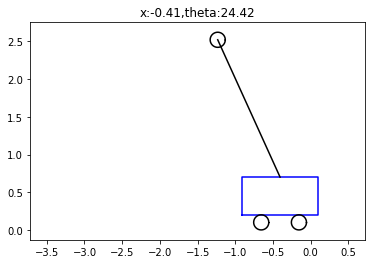

calc time:0.20157909393310547 [sec]


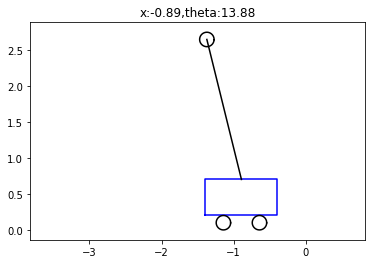

calc time:0.21430063247680664 [sec]


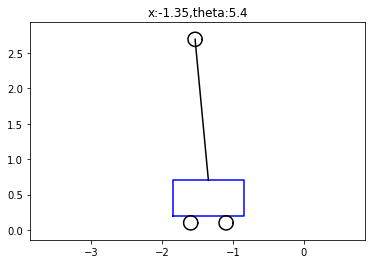

calc time:0.19746899604797363 [sec]


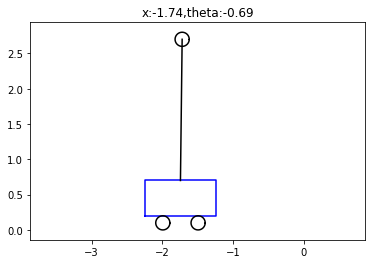

calc time:0.19838953018188477 [sec]


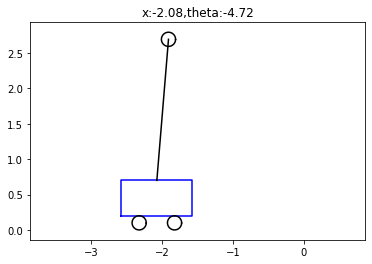

calc time:0.1988840103149414 [sec]


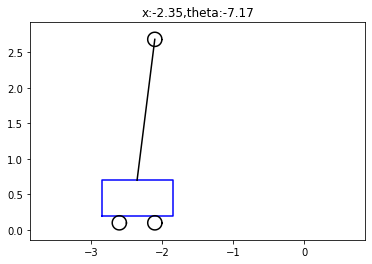

calc time:0.19907474517822266 [sec]


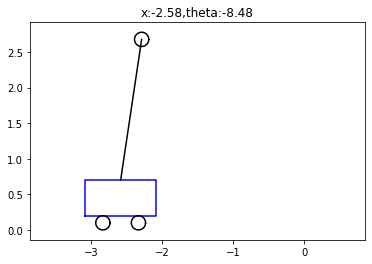

calc time:0.17860698699951172 [sec]


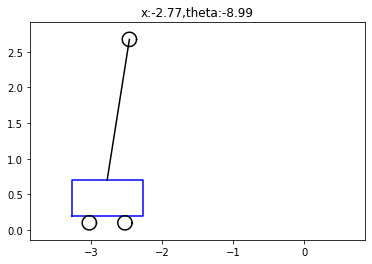

calc time:0.15049099922180176 [sec]


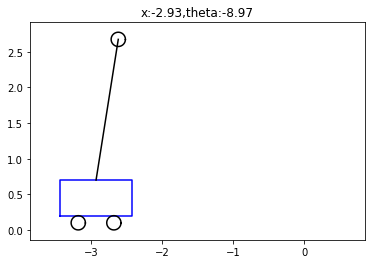

calc time:0.20118975639343262 [sec]


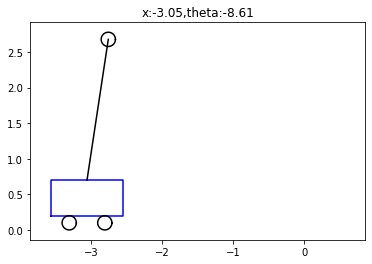

calc time:0.18766427040100098 [sec]


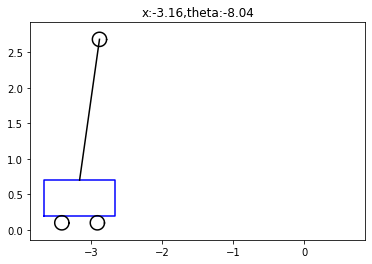

calc time:0.20647072792053223 [sec]


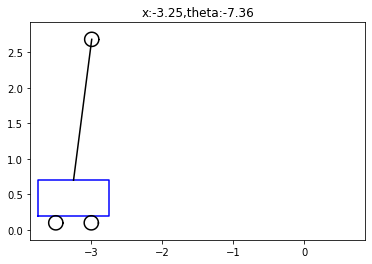

calc time:0.18071389198303223 [sec]


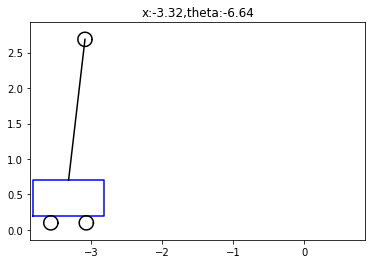

calc time:0.19492435455322266 [sec]


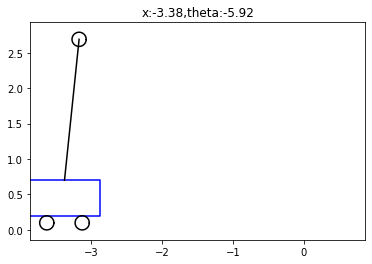

calc time:0.2056102752685547 [sec]


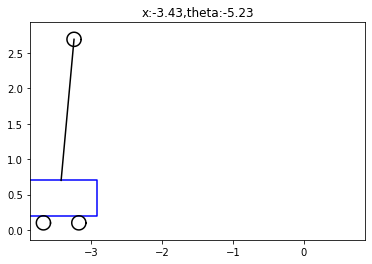

calc time:0.19213628768920898 [sec]


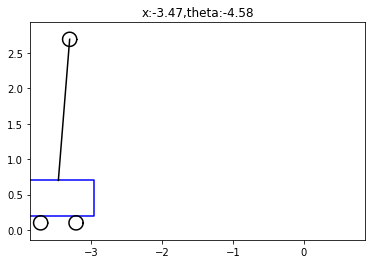

calc time:0.18100714683532715 [sec]


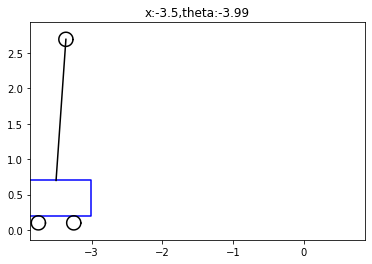

calc time:0.17714691162109375 [sec]


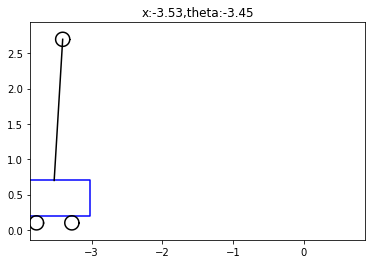

calc time:0.18174076080322266 [sec]


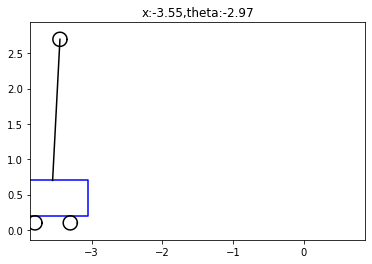

calc time:0.18364620208740234 [sec]


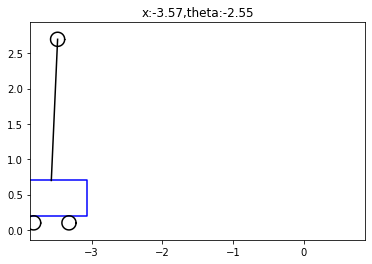

calc time:0.13417863845825195 [sec]


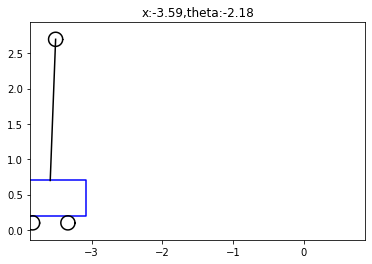

calc time:0.21592330932617188 [sec]


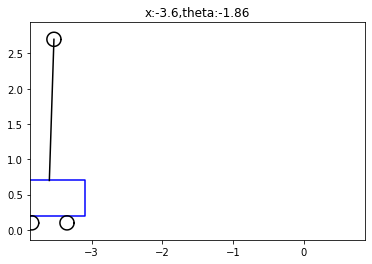

calc time:0.19280266761779785 [sec]


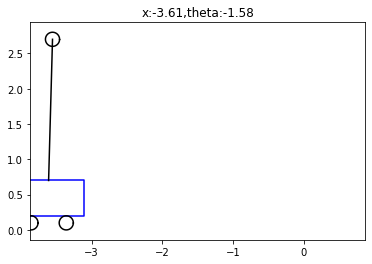

calc time:0.1909492015838623 [sec]


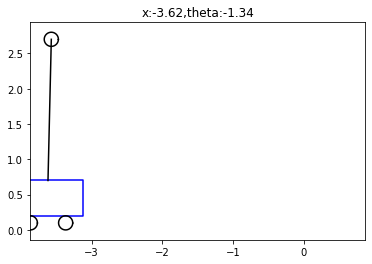

calc time:0.20061182975769043 [sec]


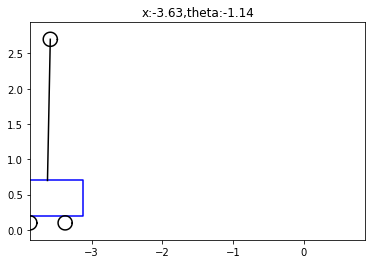

calc time:0.18938517570495605 [sec]


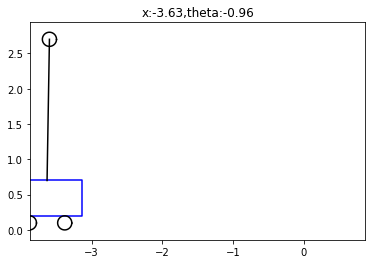

calc time:0.2031099796295166 [sec]


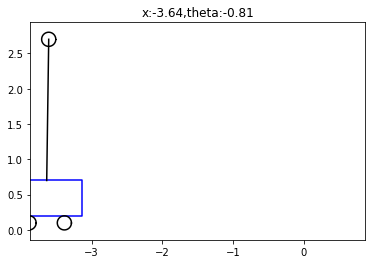

calc time:0.19384479522705078 [sec]


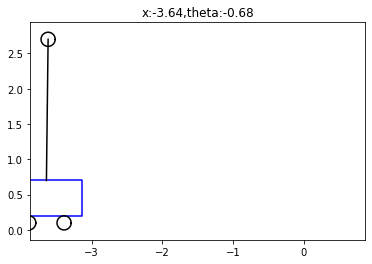

calc time:0.2048182487487793 [sec]


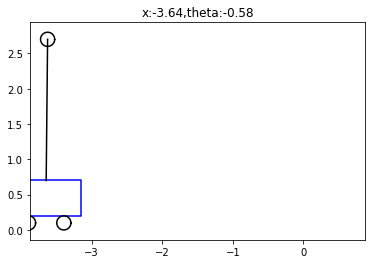

calc time:0.19917559623718262 [sec]


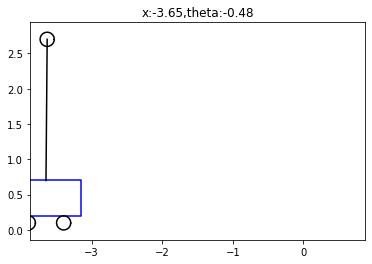

calc time:0.17298650741577148 [sec]


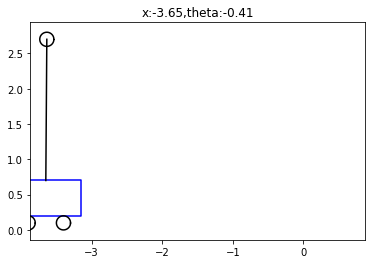

calc time:0.19161677360534668 [sec]


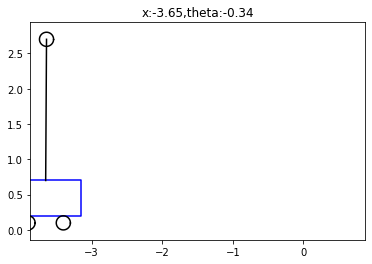

calc time:0.17905163764953613 [sec]


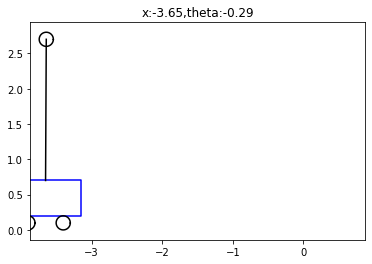

calc time:0.16865038871765137 [sec]


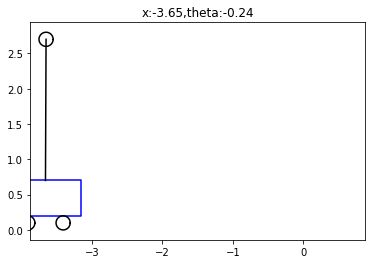

calc time:0.17750239372253418 [sec]


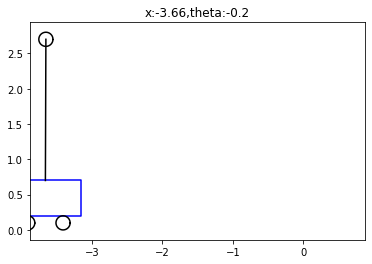

calc time:0.19497394561767578 [sec]


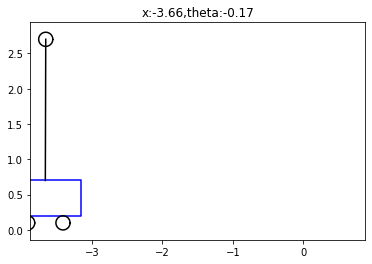

calc time:0.18470072746276855 [sec]


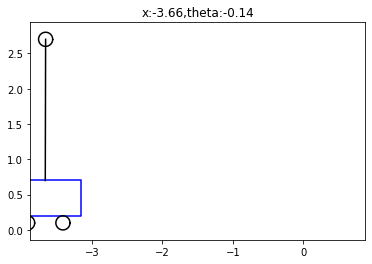

calc time:0.19826674461364746 [sec]


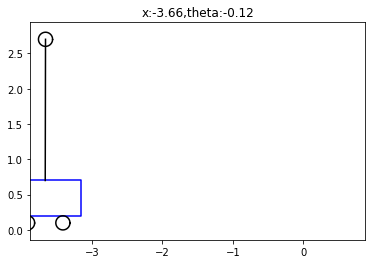

calc time:0.19707989692687988 [sec]


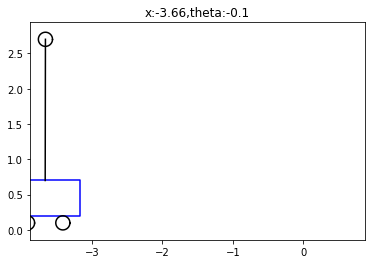

calc time:0.2034139633178711 [sec]


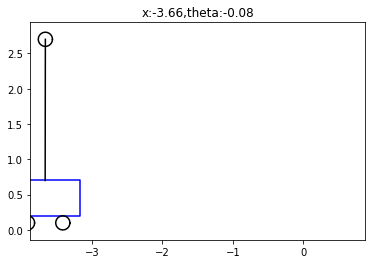

calc time:0.20199847221374512 [sec]


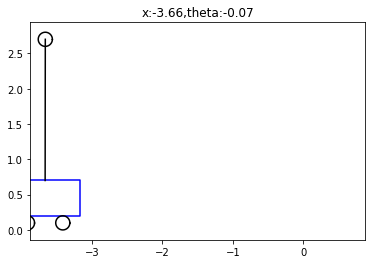

calc time:0.19071435928344727 [sec]


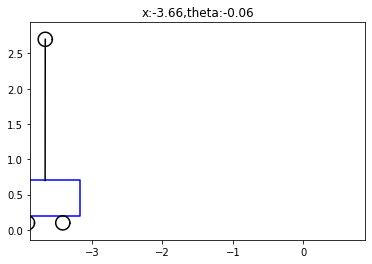

calc time:0.19353318214416504 [sec]


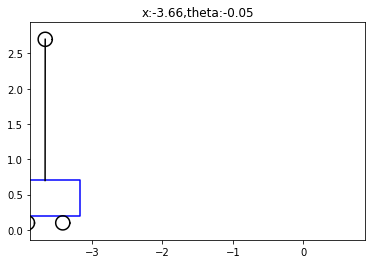

calc time:0.18752288818359375 [sec]


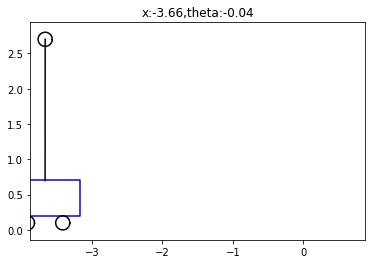

calc time:0.18959379196166992 [sec]


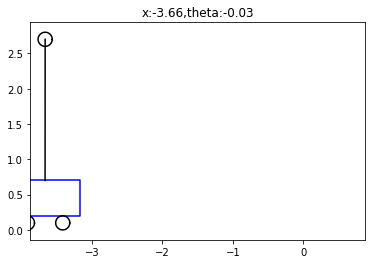

calc time:0.1685323715209961 [sec]


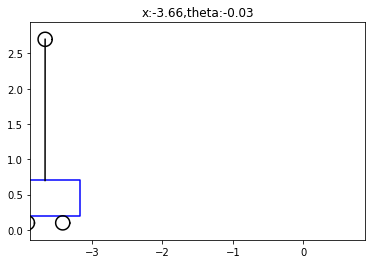

calc time:0.11168527603149414 [sec]


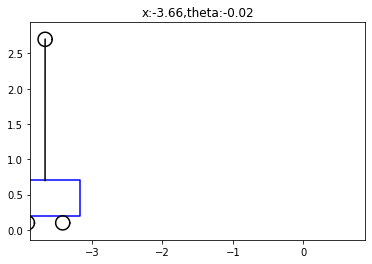

calc time:0.21603918075561523 [sec]


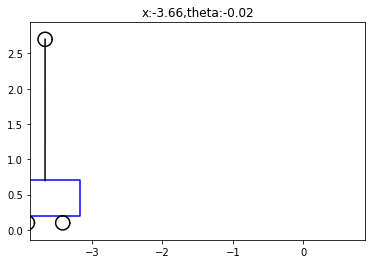

calc time:0.16046833992004395 [sec]


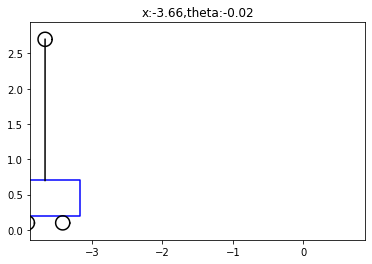

[-42.405560407808196, -9.676127794293789, 1.7514514217074701, 5.294952776323421, 5.971630364284389, 5.653909296201256, 5.036385777900036, 4.372352506166344, 3.749816910907666, 3.1950873300891134, 2.7117328218229377, 2.2952791857858146, 1.9387665725827032, 1.6348465290297998, 1.3765568488648805, 1.1575844854001247, 0.9723269283190763, 0.8158732250330201, 0.6839534112396201, 0.5728768473412472, 0.4794685408412312, 0.40100767055051406, 0.33517029736654325, 0.27997713289986687, 0.23374663743953839, 0.19505337942024922, 0.16269139479701034, 0.13564217880759713, 0.11304689216973496, 0.09418234897187495, 0.07844036141475469, 0.0653100383953022, 0.05436266471469627, 0.045238821364319406, 0.03763744216364917, 0.031306536209635055, 0.026035338036316413, 0.021647677435740566, 0.01799638824121474, 0.01495859992603539, 0.012431777673662164, 0.010330395767593734, 0.008583145921844323, 0.007130596742653014, 0.0059232331036462625, 0.004919815051190907, 0.004086005144198935, 0.003393221067988252, 0.002

In [11]:
if __name__ == '__main__':
    u1,x1 = run_normal_control()
    print(u1)
    print(len(u1))
    print(x1)
    print(len(x1))

In [12]:
u1

[-42.405560407808196,
 -9.676127794293789,
 1.7514514217074701,
 5.294952776323421,
 5.971630364284389,
 5.653909296201256,
 5.036385777900036,
 4.372352506166344,
 3.749816910907666,
 3.1950873300891134,
 2.7117328218229377,
 2.2952791857858146,
 1.9387665725827032,
 1.6348465290297998,
 1.3765568488648805,
 1.1575844854001247,
 0.9723269283190763,
 0.8158732250330201,
 0.6839534112396201,
 0.5728768473412472,
 0.4794685408412312,
 0.40100767055051406,
 0.33517029736654325,
 0.27997713289986687,
 0.23374663743953839,
 0.19505337942024922,
 0.16269139479701034,
 0.13564217880759713,
 0.11304689216973496,
 0.09418234897187495,
 0.07844036141475469,
 0.0653100383953022,
 0.05436266471469627,
 0.045238821364319406,
 0.03763744216364917,
 0.031306536209635055,
 0.026035338036316413,
 0.021647677435740566,
 0.01799638824121474,
 0.01495859992603539,
 0.012431777673662164,
 0.010330395767593734,
 0.008583145921844323,
 0.007130596742653014,
 0.0059232331036462625,
 0.004919815051190907,
 0.0

In [17]:
x1[0]

array([[ 0.        ],
       [-4.06415604],
       [ 0.6       ],
       [-1.73807802]])

In [9]:
from numpy import array, dot
from qpsolvers import solve_qp

M = array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
P = dot(M.T, M)  # this is a positive definite matrix
q = dot(array([3., 2., 3.]), M).reshape((3,))
G = array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
h = array([3., 2., -2.]).reshape((3,))
A = array([1., 1., 1.])
b = array([1.])

x = solve_qp(P, q, G, h, A, b)
print("QP solution: x = {}".format(x))

QP solution: x = [ 0.30769231 -0.69230769  1.38461538]


In [10]:
P.shape

(3, 3)

In [11]:
q.shape

(3,)

In [12]:
G.shape

(3, 3)

In [13]:
h.shape

(3,)

In [14]:
A.shape

(3,)

In [15]:
b.shape

(1,)

In [16]:
x.shape

(3,)